In [1]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pytorch-lightning
!pip install hydra-core --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=3b29f2f2f5c45b44b4c3fd5b1e0229f3c9b6280f3a6d8790da25c752c8020178
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, relu=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if relu:
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv3 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, relu=False)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, stride=1, bias=False, relu=False)        
        self.i_downsample = i_downsample
        self.relu = nn.ReLU()
    
    def forward(self, x):
      
        out = self.conv1(x)
        out = self.conv2(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class ResNet(pl.LightningModule):
    def __init__(self, ResBlock, in_channels, layer_list, planes, num_classes, num_channels=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.conv1 = ConvBlock(num_channels, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
#         print(self.conv1)
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        layers = [self._make_layer(ResBlock, layer_list[0], planes[0])]
        for i in range(1, len(layer_list)):
            layers.append(self._make_layer(ResBlock, layer_list[i], planes[i], stride=2))
        self.layers = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(planes[-1]*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.max_pooling(out)
        out = self.layers(out)
        out = out.reshape(out.shape[0], -1)
#         print(out.shape[0])
        out = self.fc(out)
        return out
    
    def _make_layer(self, ResBlock, num_blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = ConvBlock(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride, relu=False)
            
        layers.append(ResBlock(self.in_channels, planes, ii_downsample, stride))
        self.in_channels = planes * ResBlock.expansion
        for i in range(num_blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)
    
    def training_step(self, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = nn.CrossEntropyLoss()(pred, y)
        self.log('train_loss', loss)
        return loss

    def valid_step(self, batch, batch_id):
        x, y= batch
        pred = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(pred, y)
        self.log('val_loss', val_loss)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
        
    
def ResNet18(num_classes, channels=3):
    return ResNet(Block, 64, [2, 2, 2, 2], [64, 128, 256, 512], num_classes, channels, 1)

def ResNet34(num_classes, channels=3):
    return ResNet(Block, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 1)
    
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 23, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 8, 36, 3], [64, 128, 256, 512], num_classes, channels, 2)

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:03<00:00, 47965186.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet101(10).to(device)
# model.load_state_dict(torch.load("/kaggle/input/resnet-result/resnet34_cifar10_10.pt", weights_only=True))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score


def evaluate(model, plot=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    print("Accuracy: ", accuracy)
    print("F1 score: ", f1_macro)
    if plot:
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

epochs = 200
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            


Loss [19](epoch):  0.9049369299503238
Accuracy:  0.6826
F1 score:  0.6796364790167908
Loss [39](epoch):  0.6383643468170215
Accuracy:  0.7301
F1 score:  0.729839954079705
Loss [59](epoch):  0.4761312278487798
Accuracy:  0.7714
F1 score:  0.7722070153344665
Loss [79](epoch):  0.34333177086185007
Accuracy:  0.7814
F1 score:  0.7804885924333468
Loss [99](epoch):  0.25311712646270956
Accuracy:  0.7847
F1 score:  0.7831412919768517
Loss [119](epoch):  0.17984115736335135
Accuracy:  0.7839
F1 score:  0.7829907590257122
Loss [139](epoch):  0.13215023844176546
Accuracy:  0.7854
F1 score:  0.7851512890671655
Loss [159](epoch):  0.09368928005475827
Accuracy:  0.7929
F1 score:  0.7921219450886461
Loss [179](epoch):  0.0728012636908904
Accuracy:  0.7889
F1 score:  0.7888297538273602
Loss [199](epoch):  0.055899008018824525
Accuracy:  0.7903
F1 score:  0.7900861994734946


Accuracy:  0.7903
F1 score:  0.7900861994734946


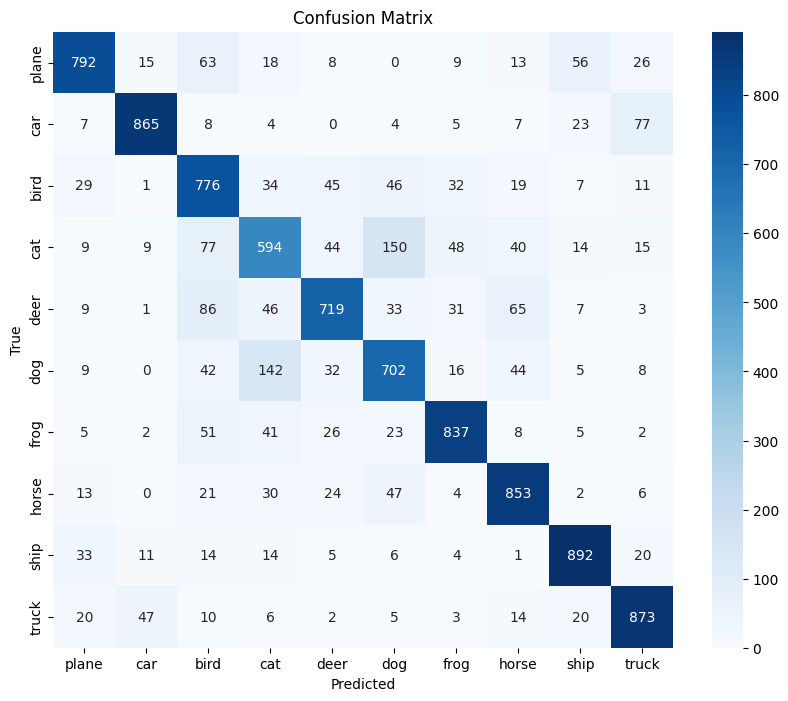

In [8]:
evaluate(model, plot=True)

In [9]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.05514200741682402
Accuracy:  0.794
F1 score:  0.7930393731853845
Loss [9](epoch):  0.049438435877280314
Accuracy:  0.795
F1 score:  0.7936904140031185
Loss [14](epoch):  0.05010394463101235
Accuracy:  0.8008
F1 score:  0.7994518086495991
Loss [19](epoch):  0.04980861548277195
Accuracy:  0.7974
F1 score:  0.7964147992689137
Loss [24](epoch):  0.04062746492359797
Accuracy:  0.7916
F1 score:  0.7897383847045566
Loss [29](epoch):  0.04138707876850939
Accuracy:  0.7987
F1 score:  0.7991918389675936
Loss [34](epoch):  0.04383348728246663
Accuracy:  0.7929
F1 score:  0.7920461456885401
Loss [39](epoch):  0.0382332867529491
Accuracy:  0.8011
F1 score:  0.7998150481114308
Loss [44](epoch):  0.039327821699673755
Accuracy:  0.7995
F1 score:  0.7975447581897456
Loss [49](epoch):  0.03573948565317923
Accuracy:  0.7979
F1 score:  0.79852604307465


In [10]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.011311402445530418
Accuracy:  0.8083
F1 score:  0.8082917391018496
Loss [9](epoch):  0.007714110887055631
Accuracy:  0.8119
F1 score:  0.8116565799531523
Loss [14](epoch):  0.005871306293119397
Accuracy:  0.811
F1 score:  0.8105933907474114
Loss [19](epoch):  0.0052499551725525605
Accuracy:  0.8113
F1 score:  0.8108582989671111
Loss [24](epoch):  0.004066400505896226
Accuracy:  0.8119
F1 score:  0.8116274488634941
Loss [29](epoch):  0.004619230436926494
Accuracy:  0.8091
F1 score:  0.8092280326898352
Loss [34](epoch):  0.0033058527496207476
Accuracy:  0.8105
F1 score:  0.8102242297753877
Loss [39](epoch):  0.004027298008448437
Accuracy:  0.8106
F1 score:  0.8102130479785394
Loss [44](epoch):  0.0035337112939489595
Accuracy:  0.8106
F1 score:  0.8103860628669853
Loss [49](epoch):  0.0038145051366324143
Accuracy:  0.8108
F1 score:  0.810605422814492


Accuracy:  0.8108
F1 score:  0.810605422814492


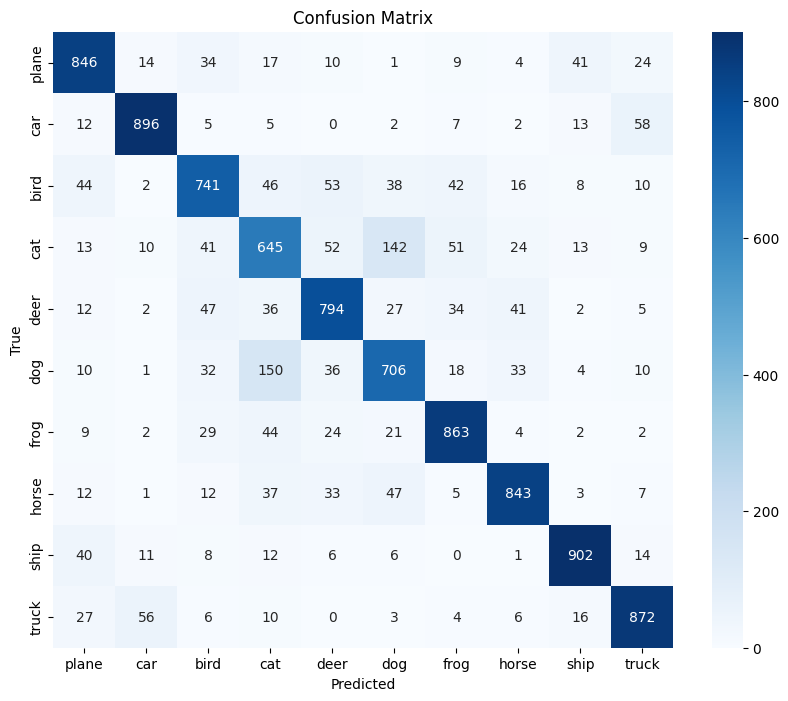

In [11]:
evaluate(model, plot=True)